https://docs.google.com/document/d/1csvWCY6Uju_NJvkKZMOArlfwbc87TmZNnq7gKR7855E/edit?usp=sharing

1번 OCR 결과와 주의어 수정사항 바운딩 

In [1]:
from google.cloud import vision
import io
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import platform
import os
import matplotlib.pyplot as plt
import csv

def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list: #img가 리스트일 때
        if type(title) == list: #title이 리스트일 때
            titles = title # 이는 이미 각 이미지에 대응하는 제목이 준비되어 있다는 뜻이므로, titles에 title 리스트를 그대로 할당
        else: #title이 리스트가 아닌 단일제목만 제공 된 경우, 모든 이미지에 같은 제목 사용 
            titles = [] #초기화
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2: # img.shape이 3차원 미만인 경우 
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg) #(행, 열, 서브플롯의 위치 인덱스)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([]) #x축과 y축의 눈금을 제거
 
        plt.show()
    else: #img가 리스트가 아닐 때 다닐 이미지로 간주하고 처리
        if len(img.shape) < 3: #img.shape가 3차원 미만인 경우 
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

def putText(image, text, x, y, color=(0, 255, 0), font_size=22):
    if type(image) == np.ndarray:
        color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(color_coverted)
 
    if platform.system() == 'Darwin':   #macOD에서
        font = 'AppleGothic.ttf'
    elif platform.system() == 'Windows':#윈도우에서 맑음
        font = 'malgun.ttf'
    else:                               #OS에서
        font = 'NanumGothic.ttf'
        
    image_font = ImageFont.truetype(font, font_size) #이미지에 텍스트를 그릴 때 사용
    font = ImageFont.load_default() # 시스템의 기본 폰트를 로드하여 폰트 객체를 생성
    draw = ImageDraw.Draw(image)
 
    draw.text((x, y), text, font=image_font, fill=color) # 텍스트를 실제 이미지 위에 그리는데 사용
    #text : 이미지에 그릴 문자열
    #(x, y): 텍스트를 그리기 시작할 위치의 좌표입니다. x는 가로 위치, y는 세로 위치를 나타냅니다. 이 좌표는 텍스트의 왼쪽 상단 모서리를 기준으로 합니다
    
    numpy_image = np.array(image)
    opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
 
    return opencv_image

###API입력######
def detect_text(path):
    """이미지 파일에서 텍스트를 감지합니다."""
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'Your Json' #json으로 발급받은 API키 입력 
    client_options = {'api_endpoint': 'eu-vision.googleapis.com'} #Google Cloud Vision API의 엔드포인트를 설정
    client = vision.ImageAnnotatorClient(client_options=client_options)#Google Cloud Vision API의 ImageAnnotatorClient 인스턴스를 생성합니다. 
    # client = vision.ImageAnnotatorClient()
    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations
    return texts

def load_terms(csv_path):
    """맞춤법 교정 용어집을 로드합니다."""
    terms_df = pd.read_csv(csv_path)
    correction_dict = dict(zip(terms_df['잘못된 표현'], terms_df['올바른 표현']))
    return correction_dict

def load_special_characters(csv_path):
    """
    .csv 파일에서 특정 문자 목록을 로드합니다.

    Parameters:
    csv_path (str): 특정 문자 목록이 저장된 .csv 파일의 경로.

    Returns:
    list: 파일에서 로드된 특정 문자 목록.
    """
    characters = []
    with open(csv_path, newline='', encoding='utf-8-sig') as csvfile: ### utf-8로 했더니 ['\ufeff(', ')']  이렇게 출력되어서 수정함 
        reader = csv.reader(csvfile)
        for row in reader:
            characters.extend(row)  # 각 행의 항목들을 리스트에 추가
    return characters

def combine_boxes_for_specific_words_1(texts, word_sequence):
    combined_texts = []
    skip_next = False

    for i, text in enumerate(texts[:-1]):  # 마지막 요소 바로 전까지 순회
        if skip_next:
            skip_next = False
            continue

        # 딕셔너리 키 접근 방식으로 수정
        description = text['description']
        next_description = texts[i + 1]['description']

        if description == word_sequence[0] and next_description == word_sequence[1]:
            # 바운딩 박스를 합침
            combined_box = {
                "locale": text.get('locale', ''),  # .get() 메서드를 사용해 안전하게 키에 접근
                "description": description + next_description,  # 띄어쓰기를 추가
                "bounding_poly": {
                    "vertices": [
                        text['bounding_poly']['vertices'][0],
                        texts[i + 1]['bounding_poly']['vertices'][1],
                        texts[i + 1]['bounding_poly']['vertices'][2],
                        text['bounding_poly']['vertices'][3]
                    ]
                }
            }
            combined_texts.append(combined_box)
            skip_next = True  # 다음 단어는 이미 처리됐으므로 건너뛰기
        else:
            combined_texts.append(text)

    if not skip_next:  # 마지막 요소 처리
        combined_texts.append(texts[-1])

    return combined_texts

def combine_boxes_for_specific_words_2(texts, special_chars):
    combined_texts = []
    i = 0

    while i < len(texts):
        # 이하 로직은 동일하며, description in [")", "("] 대신에
        # description in special_chars 조건을 사용하여 괄호 처리
        text = texts[i]
        description = text.description

        combine_with_next = False
        combine_with_prev = False

        if i > 0:
            prev_text = texts[i - 1]
            prev_right_x = prev_text.bounding_poly.vertices[1].x
            current_left_x = text.bounding_poly.vertices[0].x
            if current_left_x - prev_right_x >= 5 and description in special_chars:
                combine_with_prev = True

        if i < len(texts) - 1:
            next_text = texts[i + 1]
            next_description = next_text.description
            current_right_x = text.bounding_poly.vertices[1].x
            next_left_x = next_text.bounding_poly.vertices[0].x
            if next_left_x - current_right_x >= 5 and description in special_chars:
                combine_with_next = True

        # 이하 로직은 동일...
        if combine_with_next or combine_with_prev:
            # 다음 단어 또는 이전 단어와 합침
            new_description = description + " " + next_description if combine_with_next else prev_text.description + " " + description
            new_vertices = [
                {"x": text.bounding_poly.vertices[0].x, "y": text.bounding_poly.vertices[0].y},
                {"x": next_text.bounding_poly.vertices[1].x, "y": next_text.bounding_poly.vertices[1].y},
                {"x": next_text.bounding_poly.vertices[2].x, "y": next_text.bounding_poly.vertices[2].y},
                {"x": text.bounding_poly.vertices[3].x, "y": text.bounding_poly.vertices[3].y}
            ] if combine_with_next else [
                {"x": prev_text.bounding_poly.vertices[0].x, "y": prev_text.bounding_poly.vertices[0].y},
                {"x": text.bounding_poly.vertices[1].x, "y": text.bounding_poly.vertices[1].y},
                {"x": text.bounding_poly.vertices[2].x, "y": text.bounding_poly.vertices[2].y},
                {"x": prev_text.bounding_poly.vertices[3].x, "y": prev_text.bounding_poly.vertices[3].y}
            ]
            combined_box = {
                "description": new_description,
                "bounding_poly": {"vertices": new_vertices}
            }
            combined_texts.append(combined_box)
            i += 2 if combine_with_next else 1
        else:
            # 기존 박스를 유지하는 경우도 딕셔너리 형태로 변환하여 추가
            unchanged_box = {
                "description": description,
                "bounding_poly": {
                    "vertices": [
                        {"x": vertex.x, "y": vertex.y} for vertex in text.bounding_poly.vertices
                    ]
                }
            }
            combined_texts.append(unchanged_box)
            i += 1

    return combined_texts

def combine_boxes_for_specific_words_3(texts, special_chars):
    combined_texts = []
    i = 0

    while i < len(texts):
        text = texts[i]
        description = text.description

        combine_with_prev = False

        if i > 0:
            prev_text = texts[i - 1]
            prev_right_x = prev_text.bounding_poly.vertices[1].x
            current_left_x = text.bounding_poly.vertices[0].x
            # 현재 단어와 이전 단어 사이의 거리가 5 미만이고, 현재 단어가 특정 문자 리스트에 속하는 경우에만 합칩니다.
            if current_left_x - prev_right_x < 5 and description in special_chars:
                combine_with_prev = True

        if combine_with_prev:
            # 이전 단어와 현재 단어를 합침
            combined_box = {
                "description": prev_text.description + " " + description,
                "bounding_poly": {
                    "vertices": [
                        {"x": prev_text.bounding_poly.vertices[0].x, "y": prev_text.bounding_poly.vertices[0].y},
                        {"x": text.bounding_poly.vertices[1].x, "y": text.bounding_poly.vertices[1].y},
                        {"x": text.bounding_poly.vertices[2].x, "y": text.bounding_poly.vertices[2].y},
                        {"x": prev_text.bounding_poly.vertices[3].x, "y": prev_text.bounding_poly.vertices[3].y}
                    ]
                }
            }
            # 마지막에 추가된 합쳐진 박스를 제거하고 새로운 박스를 추가합니다.
            if combined_texts and combined_texts[-1]['description'] == prev_text.description:
                combined_texts.pop()
            combined_texts.append(combined_box)
        else:
            # 이전 단어와 합쳐지지 않는 경우, 현재 단어를 그대로 유지합니다.
            unchanged_box = {
                "description": description,
                "bounding_poly": {
                    "vertices": [
                        {"x": vertex.x, "y": vertex.y} for vertex in text.bounding_poly.vertices
                    ]
                }
            }
            combined_texts.append(unchanged_box)

        i += 1

    return combined_texts

def draw_bounding_box(image, vertices, color, text='', text_color=(255, 255, 255), font_size=22):
    """주어진 이미지에 바운딩 박스와 텍스트를 그립니다."""
    x1, y1 = vertices[0]
    x2, y2 = vertices[2]
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)  # 바운딩 박스 그리기
    if text:  # 텍스트가 제공된 경우에만 그림
        image = putText(image, text, x1, y1 - 15, color=text_color, font_size=font_size)
    return image

def correct_and_visualize(image_path, texts, correction_dict_1, correction_dict_2, correction_dict_3):
    img = cv2.imread(image_path)
    roi_img = img.copy()

    for text in texts[1:]:
        # vertices = [(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices]
        vertices = [(vertex["x"], vertex["y"]) for vertex in text["bounding_poly"]["vertices"]]
        correction_text = ''
        corrected = False

        for correction_dict, box_color, text_color, message_prefix in zip(
        [correction_dict_1, correction_dict_2, correction_dict_3], 
        [(0, 0, 255), (255, 0, 0), (0, 165, 255)],[(255, 0, 0), (0, 0, 255),(255, 165, 0)],
        ["주의어: ", "붙여쓰기: ", "띄어쓰기: "]):  # 각 사전에 대한 안내 메시지를 정의
            for wrong, correct in correction_dict.items():
                if wrong in text["description"]:
                # if wrong in text.description:
                    correction_text = f"{message_prefix} {correct}"  # 안내 메시지를 포함한 교정 텍스트
                    # correction_text = f""  # 안내 메시지를 포함한 교정 텍스트
                    # correction_text = f"{message_prefix}Correct: {correct}"  # 안내 메시지를 포함한 교정 텍스트
                    roi_img = draw_bounding_box(roi_img, vertices, box_color, correction_text, text_color, font_size=10)
                    corrected = True
                    break
            if corrected:
                break
    
    plt_imshow(["Original", "ROI"], [img, roi_img], figsize=(16, 10))

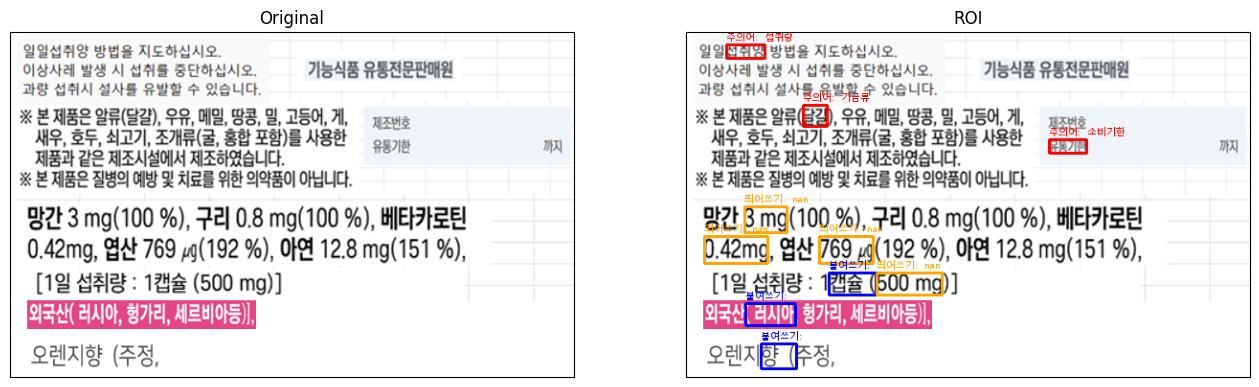

In [2]:

# 예제 사용법 (이 부분은 실제 코드에 맞게 조정 필요)
correction_dict_1 = load_terms('맞춤법용어집_주의어.csv')
correction_dict_2 = load_terms('맞춤법용어집_붙여쓰기.csv')
# correction_dict_3 = load_terms('C:\\Users\\bluecom010\\Desktop\\지의\\24_03_22_최종프로젝트\\맞춤법\\맞춤법용어집_띄어쓰기.csv')
correction_dict_3 = load_terms('맞춤법용어집_띄어쓰기_보류.csv')
special_chars_2 = load_special_characters('맞춤법용어집_붙여쓰기_특정문자.csv')
special_chars_3 = load_special_characters('맞춤법용어집_띄어쓰기_특정문자.csv')
# image_path = '../../OCR_test/test16.png'
image_path = 'test_final_2.png'
# image_path = 'C:\\Users\\bluecom010\\Desktop\\지의\\24_03_22_최종프로젝트\\OCR_test\\test_final_2.png'
texts = detect_text(image_path)  # detect_text 함수로부터 얻은 텍스트
# texts_rev1 = combine_boxes_for_specific_words_1(texts, ["유통", "기한"])
# combined_texts = combine_boxes_for_specific_words_2(texts_rev1)

# texts_rev1 = combine_boxes_for_specific_words_3(texts, special_chars_3) ##g, mg이런 단위 들이 앞에 있는 단어와 5미만일 떄 합쳐서 bbox
texts_rev2 = combine_boxes_for_specific_words_2(texts, special_chars_2) ##special_chars에 ['(',')'] 넣으면 괄호 앞단어 뒷단어가 좌표5이상 띄어져 있을 때 함꼐 bbox쳐짐
combined_texts = combine_boxes_for_specific_words_1(texts_rev2, ["유통", "기한"]) ##합쳐서 bbox치고 싶은 단어를 list로 받아서 bbox쳐지도록 함수화 시킴 ex)'유통' 다음 다음이 '기한'일 경우 함꼐 bbox쳐짐 
correct_and_visualize(image_path, combined_texts, correction_dict_1, correction_dict_2, correction_dict_3)


In [3]:
text_to_check = ' '.join([getattr(t, 'description', '').replace('\n', ' ') for t in texts])
print(text_to_check)

일일섭취양 방법을 지도하십시오. 이상사례 발생 시 섭취를 중단하십시오. 과량 섭취시 설사를 유발할 수 있습니다. 기능식품 유통전문판매원 ※ 본 제품은 알류(달걀), 우유, 메밀, 땅콩, 밀, 고등어, 게, 제조번호 새우, 호두, 쇠고기, 조개류(굴, 홍합 포함)를 사용한 제품과 같은 제조시설에서 제조하였습니다. 유통기한 까지 ※ 본 제품은 질병의 예방 및 치료를 위한 의약품이 아닙니다. 망간 3mg(100%), 구리 0.8 mg(100%), 베타카로틴 0.42mg, 엽산 769g(192%), 아연 12.8 mg(151%), [1일 섭취량 : 1캡슐 (500mg)] 외국산(러시아, 헝가리, 세르비아등)], 오렌지향 (주정, 일일 섭취양 방법 을 지도 하십시오 . 이상 사례 발생 시 섭취 를 중단 하십시오 . 과량 섭취 시 설사 를 유발할 수 있습니다 . 기능 식품 유통 전문 판매원 ※ 본 제품 은 알류 ( 달걀 ) , 우유 , 메밀 , 땅콩 , 밀 , 고등어 , 게 , 제조 번호 새우 , 호두 , 쇠고기 , 조개류 ( 굴 , 홍합 포함 ) 를 사용한 제품 과 같은 제조 시설 에서 제조 하였습니다 . 유통 기한 까지 ※ 본 제품 은 질병 의 예방 및 치료 를 위한 의약품 이 아닙니다 . 망간 3mg ( 100 % ) , 구리 0.8 mg ( 100 % ) , 베타 카로틴 0.42mg , 엽산 769g ( 192 % ) , 아연 12.8 mg ( 151 % ) , [ 1 일 섭취량 : 1 캡슐 ( 500mg ) ] 외국산 ( 러시아 , 헝가리 , 세르비아 등 ) ] , 오렌지 향 ( 주정 ,


In [7]:
texts

[locale: "ko"
description: "일일섭취양 방법을 지도하십시오.\n이상사례 발생 시 섭취를 중단하십시오.\n과량 섭취시 설사를 유발할 수 있습니다.\n기능식품 유통전문판매원\n※ 본 제품은 알류(달걀), 우유, 메밀, 땅콩, 밀, 고등어, 게, 제조번호\n새우, 호두, 쇠고기, 조개류(굴, 홍합 포함)를 사용한\n제품과 같은 제조시설에서 제조하였습니다.\n유통기한\n까지\n※ 본 제품은 질병의 예방 및 치료를 위한 의약품이 아닙니다.\n망간 3mg(100%), 구리 0.8 mg(100%), 베타카로틴\n0.42mg, 엽산 769g(192%), 아연 12.8 mg(151%),\n[1일 섭취량 : 1캡슐 (500mg)]\n외국산(러시아, 헝가리, 세르비아등)],\n오렌지향 (주정,"
bounding_poly {
  vertices {
    x: 10
    y: 14
  }
  vertices {
    x: 576
    y: 14
  }
  vertices {
    x: 576
    y: 352
  }
  vertices {
    x: 10
    y: 352
  }
}
, description: "일일"
bounding_poly {
  vertices {
    x: 14
    y: 14
  }
  vertices {
    x: 39
    y: 14
  }
  vertices {
    x: 39
    y: 28
  }
  vertices {
    x: 14
    y: 28
  }
}
, description: "섭취양"
bounding_poly {
  vertices {
    x: 42
    y: 14
  }
  vertices {
    x: 82
    y: 14
  }
  vertices {
    x: 82
    y: 28
  }
  vertices {
    x: 42
    y: 28
  }
}
, description: "방법"
bounding_poly {
  vertices {
    x: 88
   

GPT에게 맞춤법 검사시행

In [15]:
text_to_check =texts[0].description
print(text_to_check)

일일섭취양 방법을 지도하십시오.
이상사례 발생 시 섭취를 중단하십시오.
과량 섭취시 설사를 유발할 수 있습니다.
기능식품 유통전문판매원
※ 본 제품은 알류(달걀), 우유, 메밀, 땅콩, 밀, 고등어, 게, 제조번호
새우, 호두, 쇠고기, 조개류(굴, 홍합 포함)를 사용한
제품과 같은 제조시설에서 제조하였습니다.
유통기한
까지
※ 본 제품은 질병의 예방 및 치료를 위한 의약품이 아닙니다.
망간 3mg(100%), 구리 0.8 mg(100%), 베타카로틴
0.42mg, 엽산 769g(192%), 아연 12.8 mg(151%),
[1일 섭취량 : 1캡슐 (500mg)]
외국산(러시아, 헝가리, 세르비아등)],
오렌지향 (주정,


In [17]:
def combine_words(ocr_results, proximity_threshold=5):
    combined_results = []
    current_phrase = ""
    current_box = None
    last_word_end = None

    for i, result in enumerate(ocr_results):
        if i == 0: continue
        # Get the start (x_min) and end (x_max) of the bounding box for the current word
        vertices = ([(vertex.x, vertex.y)
                    for vertex in result.bounding_poly.vertices])
        x_min = vertices[0][0]
        x_max = vertices[1][0]

        if last_word_end is None or \
            (x_min - last_word_end) <= proximity_threshold:
            # Append to the current phrase
            current_phrase += result.description
            # Extend the current bounding box
            if current_box is None:
                current_box = result.bounding_poly
            else:
                current_box.vertices[1].x = vertices[1][0]
                current_box.vertices[2].x = vertices[2][0]
        else:
            # Start a new phrase and bounding box
            combined_results.append((current_phrase, current_box))
            current_phrase = result.description
            current_box = result.bounding_poly
        
        # Update the end position of the last word
        last_word_end = x_max

    # Don't forget to add the last phrase and box
    if current_phrase:
        combined_results.append((current_phrase, current_box))
    
    return combined_results

In [18]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '.json' #구글api jason path 입력
 
client_options = {'api_endpoint': 'eu-vision.googleapis.com'}

In [19]:
def detect_text(path):
    client = vision.ImageAnnotatorClient(client_options=client_options)



    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    try:
        image = vision.Image(content=content)

        response = client.text_detection(image=image)
        texts = response.text_annotations
        # print('Texts:')

        test = combine_words(texts, 5)
        # print([item[0] for item in test])
        # print([bbox[1] for bbox in test])
        
        return test
    except Exception as e:
        raise Exception(f"Error: {e}")

In [20]:
def detect_text2(path2):
    client = vision.ImageAnnotatorClient(client_options=client_options)



    with io.open(path2, 'rb') as image_file2:
        content2 = image_file2.read()

    try:
        image2 = vision.Image(content2=content2)

        response2 = client.text_detection(image2=image2)
        texts2 = response2.text_annotations
        # print('Texts:')

        test2 = combine_words(texts2, 5)
        # print([item[0] for item in test])
        # print([bbox[1] for bbox in test])
        
        return test2
    except Exception as e:
        raise Exception(f"Error: {e}")

In [21]:
result = detect_text("Work\\HrBaek\\test11.png")

In [22]:
result

[('[섭취량',
  vertices {
    x: 7
    y: 9
  }
  vertices {
    x: 74
    y: 9
  }
  vertices {
    x: 74
    y: 31
  }
  vertices {
    x: 7
    y: 31
  }),
 ('및',
  vertices {
    x: 87
    y: 9
  }
  vertices {
    x: 104
    y: 9
  }
  vertices {
    x: 104
    y: 31
  }
  vertices {
    x: 87
    y: 31
  }),
 ('섭취방법]',
  vertices {
    x: 119
    y: 9
  }
  vertices {
    x: 205
    y: 9
  }
  vertices {
    x: 205
    y: 31
  }
  vertices {
    x: 119
    y: 31
  }),
 ('1일',
  vertices {
    x: 220
    y: 9
  }
  vertices {
    x: 246
    y: 9
  }
  vertices {
    x: 246
    y: 31
  }
  vertices {
    x: 220
    y: 31
  }),
 ('1회,',
  vertices {
    x: 262
    y: 9
  }
  vertices {
    x: 296
    y: 9
  }
  vertices {
    x: 296
    y: 31
  }
  vertices {
    x: 262
    y: 31
  }),
 ('1회',
  vertices {
    x: 312
    y: 9
  }
  vertices {
    x: 338
    y: 9
  }
  vertices {
    x: 338
    y: 31
  }
  vertices {
    x: 312
    y: 31
  }),
 ('1포를',
  vertices {
    x: 356
    y: 9
 

In [23]:
import pandas as pd
from openai import OpenAI

# CSV 파일을 DataFrame으로 불러옵니다.
corrections_df = pd.read_csv('corrections.csv')

# 'original'과 'replacement' 열을 각각 리스트로 변환합니다.
originals = corrections_df['original'].tolist()
replacements = corrections_df['replacement'].tolist()

# GPT 모델에게 수정 요청
client = OpenAI(api_key='Your API')

text_to_check = ' '.join([t[0] for t in result])

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {
            "role": "system",
            "content": "너는 문장을 수정해주는 맞춤법 검사기이자 문장 검수자야"
        },
        {
            "role": "user",
            "content": f"수정할 문장{result}, csv로 인해 고친 사항은 맞춤법 검사 수정에서 제외해줘."
        }
        ,{
            "role":"assistant",
            "content": f"다음 문장에서 주어진 단어들을 대체하고 수정된 부분의 bbox 좌표를 제공해줘. 공식적인 말투로 말해줘:\n{text_to_check}\n\n교체 규칙:\n" + "\n".join([f"{o} -> {r}" for o, r in zip(originals, replacements)])
        }
        ,{
            "role":"assistant",
            "content": "너는 한국어 텍스트의 맞춤법을 검사하고 수정 제안을 하는 역할이야. 텍스트를 분석하여 맞춤법 오류가 있는 경우 모든 부분의 정확한 수정 제안과 함께 해당 bbox 좌표를 제공해줘. 공식적인 말투로 말해줘."
        }        
        ,{
            "role":"assistant",
            "content": "수정을 거친 총 문장으로 시작해서 3개의 문단으로 작성해 줘. 이때 첫번째는 수정을 거친 총 문장, 두번째는 수정을 거친 부분 변경사항으로 작성해줘. 마지막은 수정된 부분의 bbox 좌표로 마무리 해줘."
        }    
        ]
    )

correction = response.choices[0].message.content
print(correction)

맞춤법을 다시 검사해보니 수정이 필요한 부분이 있어서 다음과 같이 수정했습니다:

[수정된 총 문장] 
"섭취량 및 섭취방법] 1일 1회, 1회 1포를 섭취 하십시오. [섭취 시 주의사항] 특이체질, 알레르기체질 등은 개인에 따라 과민반응을 나타낼 수 있으므로 원료를 확인한 후 섭취 하십시오. 어린이가 함부로 섭취하지 않도록 질환이 있거나 의약품 복용 시 전문가와 상담하십시오. 일일 섭취량 방법을 지도하십시오. 이상사례 발생 시 섭취를 중단하고 전문가와 상담하십시오. 과량 섭취 시 설사를 유발할 수 있습니다."

[변경사항]
"섭취하십시오.어린이가" -> "섭취 하십시오. 어린이가"
"않도록질환이" -> "않도록 질환이"
"상담하십시오.일일섭취양" -> "상담하십시오. 일일 섭취량"
"중단하고전문가와" -> "중단하고 전문가와"
"섭취시" -> "섭취 시"

[수정된 부분의 bbox 좌표
]
"섭취 하십시오. 어린이가" : { "x": 417, "y": 9, "w": 543, "h": 31 }
"않도록 질환이" : { "x": 665, "y": 76, "w": 724, "h": 98 }
"상담하십시오. 일일 섭취량" : { "x": 315, "y": 77, "w": 395, "h": 98 }
"중단하고 전문가와" : { "x": 604, "y": 110, "w": 685, "h": 131 }
"섭취 시" : { "x": 500, "y": 110, "w": 517, "h": 131 }


원본이미지에 흰배경 추가 후 맞춤법 검사 내용 그려주는 코드

In [24]:
from PIL import Image, ImageDraw, ImageFont
import textwrap
import matplotlib.pyplot as plt 

# 이미지와 텍스트 설정
korean_font_path = 'C:\\Users\\user\\Desktop\\Dream\\FordA\\SUITE-ttf\\SUITE-Heavy.ttf'  # 폰트 파일 경로 수정
original_image_path = 'Work\\HrBaek\\test11.png'  # 이미지 파일 경로 수정
original_image = Image.open(original_image_path)
original_width, original_height = original_image.size
font_size = 20
font = ImageFont.truetype(korean_font_path, font_size)

# 텍스트의 경계 상자를 계산
draw = ImageDraw.Draw(original_image)
bbox = draw.textbbox((0, 0), text=correction, font=font)
text_width = bbox[2] - bbox[0]
text_height = bbox[3] - bbox[1]

# 텍스트가 여러 줄 필요한지 계산
lines = textwrap.wrap(correction, width=(original_width // (font_size + 5)))

# 줄 간격을 적절하게 조정합니다.
line_spacing = font_size // 2  # 줄 간격을 폰트 크기의 절반으로 설정

# 새 이미지의 높이를 조정합니다.
new_height = original_height + (line_spacing + text_height) * len(lines)

# 새 이미지 생성 및 텍스트 추가
new_image = Image.new('RGB', (original_width, new_height), 'white')
new_image.paste(original_image, (0, 0))

draw = ImageDraw.Draw(new_image)
current_y = original_height + line_spacing  # 첫 번째 텍스트 줄의 y 위치를 설정
for line in lines:
    draw.text((10, current_y), line, fill='black', font=font)
    current_y += 25   # 텍스트 높이와 줄 간격을 더해서 다음 줄의 y 위치를 설정


output_image_path = '\\result1.png'  # 출력 파일 경로 수정
new_image.save(output_image_path)

# # 이미지를 화면에 표시
# plt.imshow(new_image)
# plt.show()